# <center> Training a LeNet-5 CKN and ConvNet on MNIST </center>
In this notebook we'll set up and train a LeNet-5 convolutional kernel network (CKN) and compare the results to a LeNet-5 ConvNet on the dataset MNIST. Recall that a CKN is a kernelized version of a ConvNet.

## 1 Setting up the data
There are five main items we need to set up: the data, model, training parameters, and results and optimizer objects. First we'll set up the data. For this we need to first load the default parameters and the MNIST data loader code:

In [2]:
import sys
sys.path.append('..')
sys.path.append('../..')

from src import default_params as defaults
import src.data_loaders.mnist as mnist

There are several parameters we need to set:
- batch_size: The batch size to use for training.
- data_path: The directory where the data resides or will reside. For MNIST and CIFAR-10 if the data doesn't already exist there it will be automatically downloaded and saved there.
- num_workers: The number of threads to use when loading the data.

In [3]:
batch_size = 4096
data_path = '../data/mnist'
seed = 1
num_workers = 4

Below we'll set the seeds and the default device. If you don't have a GPU you can change the default device to 'cpu', but the code will take a long time to run.

In [4]:
import numpy as np
import random
import torch
torch.set_default_tensor_type(torch.FloatTensor)
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
defaults.device = torch.device('cuda:0')

In [5]:
# Create the data loaders
train_loader, valid_loader, test_loader = mnist.get_dataloaders(batch_size=batch_size, 
                                                                data_path=data_path,
                                                                num_workers=num_workers)

We have three different data loaders: one for each of the training, validation, and test sets. Now we will create a Data object that contains the relevant data loaders.

In [6]:
from src.opt import opt_structures
data = opt_structures.Data(train_loader, valid_loader, test_loader)

## 2 Setting up the CKN model
Next we'll set up the model. The model is specified in a config file. This file is loaded and parsed, and then the model is initialized.

In [7]:
from src.model.ckn import net, parse_config

Loading faiss with AVX2 support.


There are two parameters we will change from the version of the network specified in the config file:
1. The number of filters at each layer
2. The bandwidths of the kernels

We'll use a relatively small model, so we'll set the number of filters per layer to 32.

In [8]:
num_filters = 32
bandwidth = 0.6

In [9]:
# Load the parameters of the network
params = parse_config.load_config('../cfg/lenet-5_ckn.cfg')

# Change the number of filters per layer and the bandwidths of the kernels
nlayers = len(params['num_filters'])
params['num_filters'] = [num_filters] * nlayers
params['patch_sigma'] = [bandwidth] * nlayers

# Create the network
layers = parse_config.create_layers(params)
model = net.CKN(layers).to(defaults.device)

# # Initialize the network
model.init(train_loader)
print('Done with initialization')

Initializing layer 0
Initializing layer 1
Initializing layer 2
Initializing layer 3
Initializing layer 4
Initializing layer 5
Done with initialization


The network has now been initialized. We just need to create an object of the `Model` class. We'll save the model after training to the file `../output/temp_model.pickle`.

In [10]:
import os

save_file = os.path.join('..', 'output', 'temp_ckn')
model = opt_structures.Model(model, save_path=save_file + '_model.pickle')

## 3 Setting up the parameters
Finally, we'll set up the training parameters.  In our paper we propose optimizing CKNs via an algorithm we term the "ultimate layer reversal" (ULR) method. Consider input image-label pairs $(F_{0}^{(1)},y^{(1)}),\dots, (F_{0}^{(n)},y^{(n)})$. Let $\Psi_L(\cdot; F_{0}^{(i)})$ denote the CKN as a function of the filters $W = (W_1, \dots, W_L)$ at each layer given the input image $F_{0}^{(i)}$. The filters are constrained to lie on $\mathcal{C}$, a product of spheres. We consider the following penalized classification problem using loss $\mathcal{L}$:

$$
		\min_{V; W \in \mathcal{C}}\quad f(V,W) \equiv \frac{1}{n} \sum_{i=1}^n \mathcal{L}\left(y^{(i)}, \left\langle V, \Psi_L(W; F_{0}^{(i)})\right\rangle\right)+\lambda \Vert V\Vert_F^2.$$

The matrix $V$ parameterizes the loss function. The problem can be simplified as

$$
	\min_{V; W \in \mathcal{C}} f(V,W) = \min_{W \in \mathcal{C}}  \hat f(W) \qquad  \mbox{where} \qquad \hat f(W) \triangleq \min_V f(V,W).$$
	
If a given $W^*$ is $\epsilon$-near stationary for the simplified objective $\hat f$, then the pair $(V^*(W), W^*)$ where $V^*(W) = \arg\min_V f(V, W)$, is $\epsilon$-near stationary for the original objective $f$. Using this fact, we optimize $f$ via stochastic gradient optimization. 

At each iteration $t$ we approximate the partial objective $g_{B_t}(\cdot;W):V \rightarrow f_{B_t}(V, W)$ on a mini-batch $B_t$ by a regularized quadratic approximation and perform a projected gradient step on the inner layers. Formally, at iteration $t$, it consists of the following steps:

1. Approximate the classifier around current point $V^{(t)}$:

$$
		 g_{B_t}(V;  W)  \approx q_{g_{B_t}}^{(t)}(V; W) + \frac{\tau}{2} \|V-V^{(t)}\|_F^2
         $$
         
2. Minimize the approximation 

$$
		\hat f_{B_t}(W) = \min_V q_{g_{B_t}}^{(t)}(V; W) + \frac{\tau}{2} \|V-V^{(t)}\|_F^2$$

3. Make a projected gradient step. Letting $P_{\mathcal{C}_\ell}$ denote the projection onto the constraint set of layer $\ell$ and $\eta_t$ denote the step size at iteration $t$, set

$$
		 W_\ell^{(t+1)}  = P_{\mathcal{C}_\ell}\left(W_\ell^{(t)} - \eta_{t} P_{\mathcal{C}_\ell}\left(\nabla_{W_\ell} \hat f_{B_t}(W^{(t)})\right) \right)$$


4. Update the parameters of the classifier

$$
		V^{(t+1)}  = \underset{V}{\text{argmin}} \,q_{g_{B_t}}^{(t)}(V; W^{(t+1)}) + \frac{\tau}{2} \|V-V^{(t)}\|_F^2$$


There are a large number of parameters that we can specify. These include the following:

In [11]:
num_classes = 10               # Number of classes in the dataset
ckn = True                     # Indicates that we're using a CKN
train_w_layers = [0, 2, 4, 5]  # Layers of the network whose parameters should be trained
lambda_filters = 0             # L2 penalty on the filters at each layer except the last one
normalize = True               # Whether to normalize the features after they are output by the network
opt_method = 'ulr-sgo'         # Method used to train the network. Either 'ulr-sgo' or 'sgo'.
loss = 'cross-entropy'         # Loss function to use. Either 'cross-entropy' or 'square'
update_step_size_method = 'fixed'  # A fixed step size will be used when training the network
step_size = 2**-7              # Step size for the training
tau = 2**-7                    # Regularization parameter tau from above
num_iters = 1000               # Number of iterations for which it will run
save_path = save_file + '_params.pickle' # File where the parameters will be saved
save_every = 100               # How often to save the model, parameters, and results (after how many iterations)
eval_test_every = 10           # We'll evaluate the results every 10 iterations

In [12]:
params = opt_structures.Params(num_classes=num_classes, ckn=ckn, train_w_layers=train_w_layers, 
                               lambda_filters=lambda_filters, normalize=normalize, opt_method=opt_method, 
                               loss=loss, update_step_size_method=update_step_size_method, 
                               step_size_init=step_size, tau=tau, num_iters=num_iters, 
                               save_path=save_file + '_params.pickle',
                               eval_test_every=eval_test_every, save_every=save_every
                               )

## 4 Setting up the results and training objects
The last things we need to set up are the object that will store the results and the optimizer object.

In [13]:
from src.opt import train_network

save_path = save_file + '_results.pickle'
results = opt_structures.Results(save_path=save_path)

optimizer = train_network.TrainSupervised(data, model, params, results)

## 5 Training the CKN
Now we're ready to train the CKN!

In [14]:
optimizer.train()

Iteration 	 Train accuracy 	 Valid accuracy 	 Test accuracy 	 Train loss 	 Valid loss 	 Test loss
0 		 0.9314 		 0.9294 		 0.9362 	 0.2305 	 0.2305 	 0.2206
10 		 0.9595 		 0.9566 		 0.9601 	 0.1396 	 0.1393 	 0.1352
20 		 0.9703 		 0.9683 		 0.9693 	 0.1014 	 0.1005 	 0.0994
30 		 0.9765 		 0.9743 		 0.9762 	 0.0811 	 0.0804 	 0.0809
40 		 0.9801 		 0.9772 		 0.9793 	 0.0682 	 0.0693 	 0.0693
50 		 0.9828 		 0.9804 		 0.9801 	 0.0593 	 0.0616 	 0.0632
60 		 0.9847 		 0.9816 		 0.9811 	 0.0527 	 0.0557 	 0.0571
70 		 0.9859 		 0.9838 		 0.9823 	 0.0476 	 0.0512 	 0.0522
80 		 0.9871 		 0.9848 		 0.9834 	 0.0434 	 0.0486 	 0.0488
90 		 0.9882 		 0.9853 		 0.9855 	 0.0399 	 0.0461 	 0.0458
100 		 0.9888 		 0.9860 		 0.9857 	 0.0371 	 0.0449 	 0.0439
110 		 0.9894 		 0.9871 		 0.9870 	 0.0347 	 0.0427 	 0.0412
120 		 0.9901 		 0.9872 		 0.9878 	 0.0329 	 0.0419 	 0.0398
130 		 0.9904 		 0.9876 		 0.9877 	 0.0312 	 0.0412 	 0.0391
140 		 0.9908 		 0.9885 		 0.9883 	 0.0294 	 0.0406 	 0.037

OMP: Warning #190: Forking a process while a parallel region is active is potentially unsafe.


170 		 0.9918 		 0.9889 		 0.9898 	 0.0262 	 0.0395 	 0.0343
180 		 0.9922 		 0.9890 		 0.9897 	 0.0247 	 0.0390 	 0.0333
190 		 0.9926 		 0.9886 		 0.9897 	 0.0238 	 0.0379 	 0.0328
200 		 0.9931 		 0.9890 		 0.9908 	 0.0228 	 0.0376 	 0.0319
210 		 0.9934 		 0.9896 		 0.9907 	 0.0221 	 0.0380 	 0.0311
220 		 0.9936 		 0.9894 		 0.9905 	 0.0212 	 0.0379 	 0.0315
230 		 0.9938 		 0.9896 		 0.9907 	 0.0207 	 0.0375 	 0.0311
240 		 0.9941 		 0.9896 		 0.9906 	 0.0201 	 0.0377 	 0.0317
250 		 0.9942 		 0.9901 		 0.9911 	 0.0193 	 0.0373 	 0.0308
260 		 0.9946 		 0.9899 		 0.9908 	 0.0186 	 0.0383 	 0.0303
270 		 0.9946 		 0.9905 		 0.9911 	 0.0181 	 0.0377 	 0.0297
280 		 0.9949 		 0.9904 		 0.9912 	 0.0176 	 0.0376 	 0.0292
290 		 0.9949 		 0.9900 		 0.9911 	 0.0170 	 0.0375 	 0.0298
300 		 0.9950 		 0.9902 		 0.9914 	 0.0167 	 0.0372 	 0.0291
310 		 0.9952 		 0.9902 		 0.9912 	 0.0160 	 0.0374 	 0.0294
320 		 0.9953 		 0.9899 		 0.9914 	 0.0155 	 0.0374 	 0.0294
330 		 0.9953 		 0.9897 

## 6 Setting up and training the corresponding ConvNet
Now we'll see what we get with the corresponding ConvNet. The steps to set up and run it are similar.

In [15]:
from src.model.convnet import lenet

# Load and initialize the model
model = lenet.LeNet5(nfilters=num_filters, locally_connected_layer=False, bias=True)
model.to(defaults.device).apply(lenet.init_normal)

# Training parameters that differ from above
ckn = False                    # Indicates that we're using a ConvNet
train_w_layers = None          # Layers of the network whose parameters should be trained. None => all.
lambda_filters = 2**-7         # L2 penalty on the filters at each layer except the last one
step_size = 2**-4              # Step size for the training
save_file = os.path.join('..', 'output', 'temp_convnet')
save_path = save_file + '_params.pickle' # File where the parameters will be saved

# Set up the data, parameters, model, optimizer, and results objects
data = opt_structures.Data(train_loader, valid_loader, test_loader)
params = opt_structures.Params(num_classes=num_classes, ckn=ckn, train_w_layers=train_w_layers,
                               lambda_filters=lambda_filters, normalize=normalize, 
                               update_step_size_method=update_step_size_method, step_size_init=step_size,
                               tau=tau, num_iters=num_iters, save_path=save_file + '_params.pickle',
                               eval_test_every=eval_test_every, save_every=500)
model = opt_structures.Model(model, save_path=save_file + '_model.pickle')
results = opt_structures.Results(save_path=save_file + '_results.pickle')
optimizer = train_network.TrainSupervised(data, model, params, results)

# Train the network
optimizer.train()

Iteration 	 Train accuracy 	 Valid accuracy 	 Test accuracy 	 Train loss 	 Valid loss 	 Test loss
0 		 0.7328 		 0.7280 		 0.7361 	 0.8255 	 0.8350 	 0.7981
10 		 0.8389 		 0.8346 		 0.8394 	 0.5094 	 0.5255 	 0.5011
20 		 0.8686 		 0.8633 		 0.8702 	 0.4185 	 0.4316 	 0.4106
30 		 0.8867 		 0.8830 		 0.8893 	 0.3640 	 0.3734 	 0.3546
40 		 0.8984 		 0.8930 		 0.8982 	 0.3305 	 0.3389 	 0.3243
50 		 0.9085 		 0.9044 		 0.9093 	 0.2986 	 0.3068 	 0.2929
60 		 0.9153 		 0.9147 		 0.9188 	 0.2764 	 0.2804 	 0.2692
70 		 0.9224 		 0.9193 		 0.9235 	 0.2557 	 0.2624 	 0.2514
80 		 0.9279 		 0.9227 		 0.9290 	 0.2395 	 0.2456 	 0.2368
90 		 0.9320 		 0.9271 		 0.9320 	 0.2254 	 0.2325 	 0.2247
100 		 0.9354 		 0.9311 		 0.9346 	 0.2131 	 0.2208 	 0.2119
110 		 0.9374 		 0.9345 		 0.9371 	 0.2056 	 0.2131 	 0.2056
120 		 0.9400 		 0.9366 		 0.9396 	 0.1989 	 0.2074 	 0.1972
130 		 0.9421 		 0.9384 		 0.9398 	 0.1907 	 0.1998 	 0.1902
140 		 0.9449 		 0.9407 		 0.9446 	 0.1804 	 0.1887 	 0.182

OMP: Warning #190: Forking a process while a parallel region is active is potentially unsafe.


250 		 0.9590 		 0.9567 		 0.9571 	 0.1332 	 0.1429 	 0.1372
260 		 0.9593 		 0.9563 		 0.9581 	 0.1313 	 0.1413 	 0.1319
270 		 0.9605 		 0.9585 		 0.9587 	 0.1280 	 0.1396 	 0.1314
280 		 0.9623 		 0.9576 		 0.9617 	 0.1239 	 0.1347 	 0.1231
290 		 0.9622 		 0.9592 		 0.9608 	 0.1226 	 0.1333 	 0.1256
300 		 0.9612 		 0.9582 		 0.9590 	 0.1263 	 0.1372 	 0.1298
310 		 0.9639 		 0.9613 		 0.9633 	 0.1165 	 0.1276 	 0.1182
320 		 0.9648 		 0.9611 		 0.9630 	 0.1146 	 0.1258 	 0.1148
330 		 0.9655 		 0.9627 		 0.9632 	 0.1128 	 0.1232 	 0.1159


OMP: Warning #190: Forking a process while a parallel region is active is potentially unsafe.


340 		 0.9640 		 0.9608 		 0.9611 	 0.1172 	 0.1278 	 0.1223
350 		 0.9663 		 0.9624 		 0.9643 	 0.1095 	 0.1224 	 0.1118
360 		 0.9667 		 0.9637 		 0.9656 	 0.1069 	 0.1186 	 0.1086
370 		 0.9675 		 0.9645 		 0.9655 	 0.1056 	 0.1168 	 0.1072
380 		 0.9682 		 0.9651 		 0.9644 	 0.1042 	 0.1154 	 0.1099
390 		 0.9666 		 0.9648 		 0.9648 	 0.1091 	 0.1191 	 0.1068
400 		 0.9684 		 0.9645 		 0.9666 	 0.1021 	 0.1136 	 0.1030
410 		 0.9689 		 0.9665 		 0.9669 	 0.0994 	 0.1108 	 0.1028
420 		 0.9698 		 0.9673 		 0.9683 	 0.0981 	 0.1101 	 0.0996


OMP: Warning #190: Forking a process while a parallel region is active is potentially unsafe.


430 		 0.9696 		 0.9657 		 0.9684 	 0.0978 	 0.1099 	 0.1004
440 		 0.9706 		 0.9659 		 0.9684 	 0.0956 	 0.1075 	 0.0996
450 		 0.9709 		 0.9677 		 0.9690 	 0.0940 	 0.1064 	 0.0975
460 		 0.9716 		 0.9680 		 0.9683 	 0.0925 	 0.1052 	 0.0970
470 		 0.9716 		 0.9678 		 0.9700 	 0.0930 	 0.1046 	 0.0958
480 		 0.9724 		 0.9684 		 0.9695 	 0.0904 	 0.1026 	 0.0948
490 		 0.9728 		 0.9695 		 0.9706 	 0.0889 	 0.1014 	 0.0931
500 		 0.9719 		 0.9689 		 0.9698 	 0.0909 	 0.1022 	 0.0921
510 		 0.9729 		 0.9689 		 0.9706 	 0.0878 	 0.0997 	 0.0915
520 		 0.9732 		 0.9694 		 0.9712 	 0.0873 	 0.0991 	 0.0892
530 		 0.9742 		 0.9703 		 0.9721 	 0.0848 	 0.0975 	 0.0885
540 		 0.9742 		 0.9705 		 0.9722 	 0.0844 	 0.0968 	 0.0882
550 		 0.9742 		 0.9710 		 0.9715 	 0.0844 	 0.0975 	 0.0894
560 		 0.9747 		 0.9707 		 0.9723 	 0.0825 	 0.0957 	 0.0890
570 		 0.9752 		 0.9710 		 0.9726 	 0.0814 	 0.0941 	 0.0858
580 		 0.9756 		 0.9712 		 0.9734 	 0.0803 	 0.0933 	 0.0859
590 		 0.9757 		 0.9719 

## 6 Examining the results
Now we can load and compare the results from the two networks. As the networks and learning rates are not the same, we would not expect the performance at each iteration to be the same. 

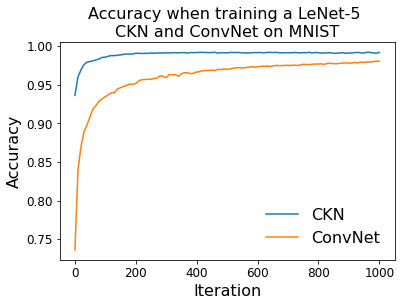

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle

ckn_results = pickle.load(open('../output/temp_ckn_results.pickle', 'rb'))
convnet_results = pickle.load(open('../output/temp_convnet_results.pickle', 'rb'))

plt.plot(list(ckn_results['test_accuracy'].keys()), list(ckn_results['test_accuracy'].values()), label='CKN')
plt.plot(list(convnet_results['test_accuracy'].keys()), list(convnet_results['test_accuracy'].values()), 
         label='ConvNet')

plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy when training a LeNet-5 \nCKN and ConvNet on MNIST', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(frameon=False, fontsize=16)
plt.show()